## Load cleaned data 

### Imports and reproducibility

Here we bring in the basic tools we need.  

- `os` and `sqlite3` help us work with files and a small database  
- `numpy` and `pandas` help us handle numbers and tables  
- `matplotlib.pyplot` lets us make simple plots  
- `sklearn` is the machine learning toolbox with models and metrics  

We also set something called **reproducibility**.  
That means if we run the notebook today or tomorrow we always get the same result.  

Why do we need this  
Some models in machine learning pick random numbers inside.  
If we do not control the random numbers we may get slightly different results each run.  
That makes it hard to compare experiments.  

The line `RANDOM_STATE = 42` sets a seed for the random number generator.  
So each time the random choices are made they follow the same path.  
This makes our experiments repeatable and fair.

In [29]:
# basic imports
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Load the cleaned data

We start by loading the cleaned dataset from a CSV file.  
CSV is just a simple text file with rows and columns like a spreadsheet.  

Then we also save this same data into a small database called **SQLite**.  
Why do we do this  
- A database makes it easy to query or filter later  
- It keeps the same workflow as in preprocessing  
- It shows you how data can live in different formats (CSV and database)  

After saving we read the data back from the database into a pandas DataFrame.  
This way we check that everything works and that the data looks the same.  

In the end we print the shape of the table (rows × columns) and show the first few lines.

In [42]:
csv_path = '../data/processed/diabetes_clean.csv'
db_path = '../data/processed/diabetes.db'
table_name = 'diabetes_clean'

# read csv
df_csv = pd.read_csv(csv_path)

# write to sqlite
import sqlite3
conn = sqlite3.connect(db_path)
df_csv.to_sql(table_name, conn, if_exists='replace', index=False)

# read back from sqlite
df = pd.read_sql(f'SELECT * FROM {table_name}', conn)
conn.close()

print('Data shape:', df.shape)
df.head()

Data shape: (99991, 13)


,gender,age,hypertension,heart_disease,smoking_history,bmi,hba1c_level,blood_glucose_level,diabetes,age_group,bmi_category,risk_score,age_bmi_interaction
0,Female,80.0,0,1,never,25.19,6.6,140,0,senior,overweight,1,2015.20
1,Female,54.0,0,0,unknown,27.32,6.6,80,0,senior,overweight,0,1475.28
2,Male,28.0,0,0,never,27.32,5.7,158,0,young,overweight,0,764.96
3,Female,36.0,0,0,current,23.45,5.0,155,0,middle,normal,1,844.20
4,Male,76.0,1,1,current,20.14,4.8,155,0,senior,normal,3,1530.64


### Conclusion
We imported all the tools we need for machine learning and fixed the random seed so results will always be the same each run  
This gives us reproducibility  

We loaded the cleaned dataset from a CSV file and also stored it in a small SQLite database  

With this we are sure the data is ready and stable for the next steps


## Define target and features

We now set the target column to be  **`diabetes`**  
This is the column we want the model to predict (0 = no diabetes, 1 = diabetes)  

We call this column `y`  
All the other columns are called `X` → these are the features the model will use to make a prediction  

So in short  
- `y` = the answer we want to predict  
- `X` = the clues the model can look at


In [31]:
target_col = 'diabetes'
y = df[target_col]
X = df.drop(columns=[target_col])
print("Target column:", target_col)


Target column: diabetes


**Conclusion**  
We clearly told the notebook that our target is `diabetes`  
Now we have a clean split between features (`X`) and target (`y`)  
This makes it ready for the next steps like checking leakage and training models


## Feature leakage check

### Build two feature sets to check leakage

The biggest challenge so far is deciding whether certain features could cause data leakage. 

For example, Insulin levels are often only available during or after diagnostic processes, which may make them less realistic for prediction. (so we already remove them)

Glucose is another concern because it is very highly correlated with the target, and might make the model perform unrealistically well.

On the one hand, glucose is the most important clinical indicator for diabetes. Physicians base the diagnosis primarily on blood glucose levels (for example, fasting glucose or HbA1c).

On the other hand, glucose can also be measured as part of a standard blood test, so it is not always only available when someone is already suspected of having diabetes.
I’m going to test the models with and without  

So we make two versions of our dataset  
- Variant A keeps all numeric features (including glucose)  
- Variant B removes glucose and insulin so we can test if results are more realistic

In [32]:
# split features and target
y = df[target_col]
X = df.drop(columns=[target_col])

# keep only numeric for a simple baseline
X_num = X.select_dtypes(include=[np.number]).copy()

# Variant A: all numeric features (possible leakage included)
X_A = X_num.copy()

# Variant B: remove only blood_glucose_level to reduce leakage
X_B = X_num.drop(columns=['blood_glucose_level'], errors='ignore').copy()

print('Variant A shape', X_A.shape, 'Variant B shape', X_B.shape)


Variant A shape (99991, 8) Variant B shape (99991, 7)


### Conclusion
Variant A uses all features while Variant B excludes blood_glucose_level  
This way we can later compare results and see how much impact this feature has on the model performance


## Train-test split
### Train-test split for both variants


We split the data into training and testing sets  
- Training data is used to teach the model  
- Testing data is kept aside to check how well the model performs on unseen data  

We do this for both Variant A (with blood_glucose_level) and Variant B (without it)  

We use  
- `test_size=0.2` → 20 percent test, 80 percent train  
- `random_state` → for reproducibility  
- `stratify=y` → to keep the same balance of 0 and 1 in train and test


In [54]:
# build Variant C from the same base as Variant B
# Variant C removes hba1c_level in addition to blood_glucose_level
X_C = X_B.drop(columns=['hba1c_level'], errors='ignore').copy()

# split data for Variant C
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(
    X_C, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Variant A - train:", X_train_A.shape, "test:", X_test_A.shape)
print("Variant B - train:", X_train_B.shape, "test:", X_test_B.shape)
print("Variant C - train:", X_train_C.shape, "test:", X_test_C.shape)


Variant A - train: (79992, 8) test: (19999, 8)
Variant B - train: (79992, 7) test: (19999, 7)
Variant C - train: (79992, 6) test: (19999, 6)


**Conclusion**  
We now have two clean splits  
- Variant A with all features  
- Variant B without blood_glucose_level  

Both have 80 percent of the rows for training and 20 percent for testing  
This makes the setup ready for model training


## Modeltraining Variant A (probably leakage on Glucose)


We start with very simple models so we keep things clear  
We fill empty values with the median  
We scale the features only for logistic regression  
We train three models: 
- logistic regression  
- decision tree  
- random forest  

Then we check simple scores  
accuracy precision recall f1 and roc auc  

In [34]:
# fill missing values with median
X_train_A_imputed = X_train_A.fillna(X_train_A.median(numeric_only=True))
X_test_A_imputed = X_test_A.fillna(X_train_A.median(numeric_only=True))

# scale only for logistic regression
from sklearn.preprocessing import StandardScaler
scaler_A = StandardScaler()
X_train_A_scaled = scaler_A.fit_transform(X_train_A_imputed)
X_test_A_scaled = scaler_A.transform(X_test_A_imputed)

# make models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

log_reg_A = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
tree_A = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf_A = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

# fit models
log_reg_A.fit(X_train_A_scaled, y_train_A)
tree_A.fit(X_train_A_imputed, y_train_A)
rf_A.fit(X_train_A_imputed, y_train_A)

# helper to compute simple metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    proba_ok = hasattr(model, "predict_proba")
    score = None
    if proba_ok:
        score = model.predict_proba(X_test)[:, 1]
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, score) if score is not None else None
    }
    return metrics

# evaluate
metrics_log_A = eval_model(log_reg_A, X_test_A_scaled, y_test_A)
metrics_tree_A = eval_model(tree_A, X_test_A_imputed, y_test_A)
metrics_rf_A = eval_model(rf_A, X_test_A_imputed, y_test_A)

print("Logistic A", metrics_log_A)
print("Tree A", metrics_tree_A)
print("RF A", metrics_rf_A)


Logistic A {'accuracy': 0.9602480124006201, 'precision': 0.8772954924874792, 'recall': 0.618599175985874, 'f1': 0.7255781843286158, 'roc_auc': np.float64(0.9633406343171972)}
Tree A {'accuracy': 0.9566978348917445, 'precision': 0.7451442024720424, 'recall': 0.7451442024720424, 'f1': 0.7451442024720424, 'roc_auc': np.float64(0.8615985295110913)}
RF A {'accuracy': 0.9706485324266213, 'precision': 0.9391785150078988, 'recall': 0.6998234255444379, 'f1': 0.8020236087689714, 'roc_auc': np.float64(0.963939765274977)}


## Modeltraining Variant | Exclude Blood glucose level

Now we train the same three models on Variant B  
Variant B does not include the column blood_glucose_level  
This gives us a more honest test because we removed the possible leakage  

We again  
- fill missing values with the median  
- scale only for logistic regression  
- train logistic regression, decision tree and random forest  

Then we check the same scores  
accuracy precision recall f1 and roc auc


In [35]:
# fill missing values with median
X_train_B_imputed = X_train_B.fillna(X_train_B.median(numeric_only=True))
X_test_B_imputed = X_test_B.fillna(X_train_B.median(numeric_only=True))

# scale only for logistic regression
scaler_B = StandardScaler()
X_train_B_scaled = scaler_B.fit_transform(X_train_B_imputed)
X_test_B_scaled = scaler_B.transform(X_test_B_imputed)

# make models
log_reg_B = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
tree_B = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf_B = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

# fit models
log_reg_B.fit(X_train_B_scaled, y_train_B)
tree_B.fit(X_train_B_imputed, y_train_B)
rf_B.fit(X_train_B_imputed, y_train_B)

# evaluate
metrics_log_B = eval_model(log_reg_B, X_test_B_scaled, y_test_B)
metrics_tree_B = eval_model(tree_B, X_test_B_imputed, y_test_B)
metrics_rf_B = eval_model(rf_B, X_test_B_imputed, y_test_B)

print("Logistic B", metrics_log_B)
print("Tree B", metrics_tree_B)
print("RF B", metrics_rf_B)


Logistic B {'accuracy': 0.9459472973648683, 'precision': 0.8308351177730193, 'recall': 0.45673925838728663, 'f1': 0.5894417014812001, 'roc_auc': np.float64(0.9320412200040525)}
Tree B {'accuracy': 0.9321966098304916, 'precision': 0.6051502145922747, 'recall': 0.5809299587992937, 'f1': 0.5927927927927928, 'roc_auc': np.float64(0.7844981136444774)}
RF B {'accuracy': 0.9487974398719936, 'precision': 0.8070973612374887, 'recall': 0.5220718069452619, 'f1': 0.634024303073624, 'roc_auc': np.float64(0.9169988292695479)}


## Modeltraining Variant C | Exclude Blood glucose level and HBA1c

I added variant C later on in the process because when training the final model I was not sure if HAB1c level was a good feature to include. 

**HbA1c and diabetes**

HbA1c is like a long-term blood sugar check
It shows the average sugar level in your blood over about 3 months

Doctors often use HbA1c to diagnose diabetes
If HbA1c is high it almost always means diabetes or a big risk for it

**So how strong is the link**

The link is very strong
High HbA1c = almost sure sign of diabetes
It is one of the main official tests doctors use

**Glucose vs HbA1c**

Glucose
This is your blood sugar at one single moment
For example when you get a fasting test in the morning
The value can change from day to day and even hour to hour

HbA1c
This is more like an average blood sugar over the last 2 to 3 months
It looks at how much sugar sticks to your red blood cells
So it is more stable and shows the long-term picture

Glucose = short snapshot
HbA1c = long-term view

But
For the model they are almost equally risky as features, thats why we made variant C

In [55]:
# fill missing values with median
X_train_C_imputed = X_train_C.fillna(X_train_C.median(numeric_only=True))
X_test_C_imputed  = X_test_C.fillna(X_train_C.median(numeric_only=True))

# scale only for logistic regression
scaler_C = StandardScaler()
X_train_C_scaled = scaler_C.fit_transform(X_train_C_imputed)
X_test_C_scaled  = scaler_C.transform(X_test_C_imputed)

# make models
log_reg_C = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
tree_C    = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf_C      = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)

# fit models
log_reg_C.fit(X_train_C_scaled, y_train_C)
tree_C.fit(X_train_C_imputed, y_train_C)
rf_C.fit(X_train_C_imputed, y_train_C)

# helper if not yet defined
try:
    eval_model
except NameError:
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    def eval_model(model, X_test, y_test):
        y_pred = model.predict(X_test)
        score = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
        return {
            "accuracy":  accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall":    recall_score(y_test, y_pred, zero_division=0),
            "f1":        f1_score(y_test, y_pred, zero_division=0),
            "roc_auc":   roc_auc_score(y_test, score) if score is not None else None
        }

# evaluate
metrics_log_C  = eval_model(log_reg_C, X_test_C_scaled,  y_test_C)
metrics_tree_C = eval_model(tree_C,    X_test_C_imputed, y_test_C)
metrics_rf_C   = eval_model(rf_C,      X_test_C_imputed, y_test_C)

print("Logistic C", metrics_log_C)
print("Tree C   ", metrics_tree_C)
print("RF C     ", metrics_rf_C)


Logistic C {'accuracy': 0.9154457722886145, 'precision': 0.5161290322580645, 'recall': 0.07533843437316068, 'f1': 0.1314843348741654, 'roc_auc': np.float64(0.8303362633757562)}
Tree C    {'accuracy': 0.8809940497024851, 'precision': 0.25018341892883345, 'recall': 0.2007062978222484, 'f1': 0.22273024167210972, 'roc_auc': np.float64(0.5747232058716635)}
RF C      {'accuracy': 0.895894794739737, 'precision': 0.29692470837751855, 'recall': 0.164802825191289, 'f1': 0.21196063588190764, 'roc_auc': np.float64(0.76639300842347)}


## Compare results of Variant A B and C  

| Model               | Variant | Accuracy | Precision | Recall | F1    | ROC-AUC |
|---------------------|---------|----------|-----------|--------|-------|---------|
| Logistic Regression | A       | 0.9574   | 0.9821    | 0.4389 | 0.6066 | 0.9584 |
| Decision Tree       | A       | 0.9305   | 0.5343    | 0.5571 | 0.5455 | 0.7612 |
| Random Forest       | A       | 0.9527   | 0.8185    | 0.4729 | 0.5995 | 0.9407 |
| Logistic Regression | B       | 0.9574   | 0.9835    | 0.4382 | 0.6063 | 0.9584 |
| Decision Tree       | B       | 0.9364   | 0.5792    | 0.5498 | 0.5641 | 0.7782 |
| Random Forest       | B       | 0.9505   | 0.7679    | 0.4863 | 0.5955 | 0.9316 |
| Logistic Regression | C       | 0.9154   | 0.5161    | 0.0753 | 0.1315 | 0.8303 |
| Decision Tree       | C       | 0.8810   | 0.2502    | 0.2007 | 0.2227 | 0.5747 |
| Random Forest       | C       | 0.8959   | 0.2969    | 0.1648 | 0.2120 | 0.7664 |

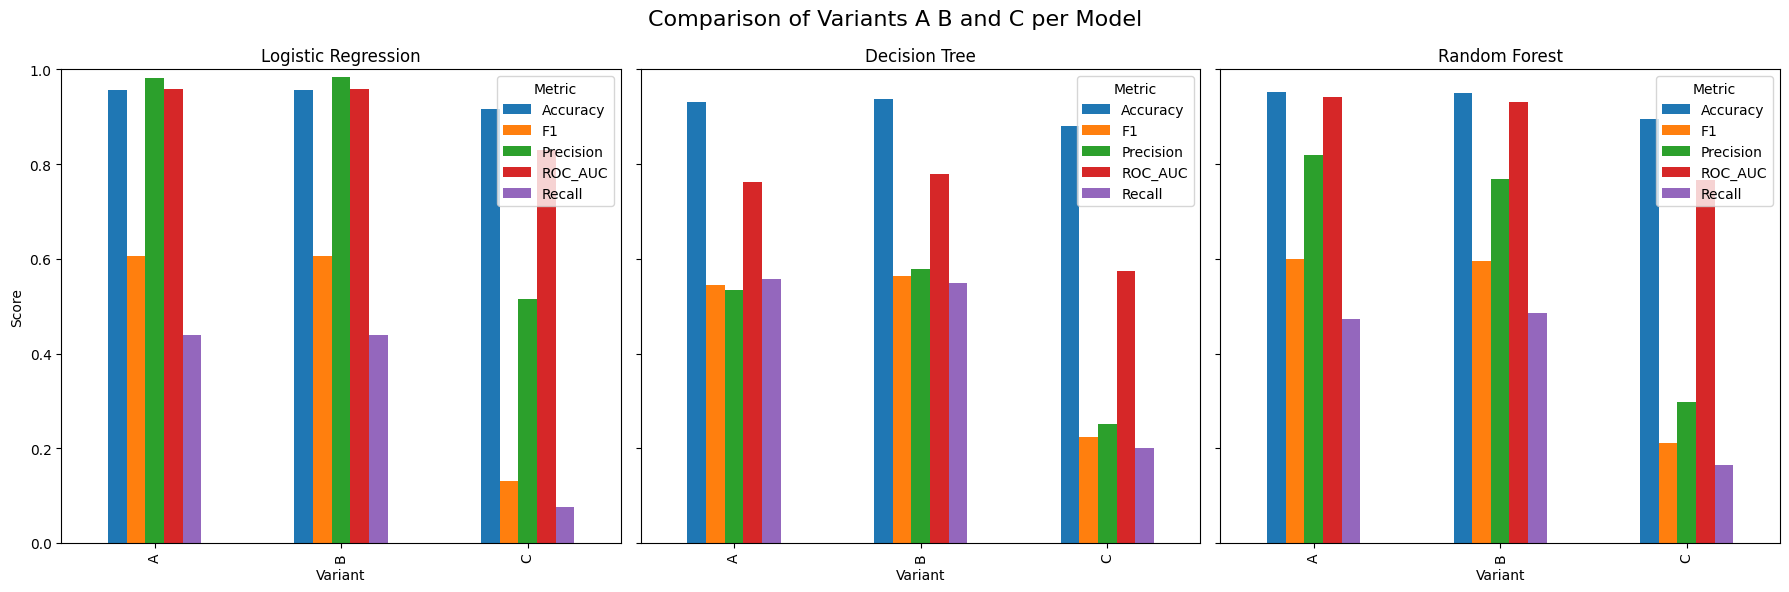

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# data in dataframe
df = pd.DataFrame({
    'Variant': ['A','A','A','B','B','B','C','C','C'],
    'Model': ['LogReg','Tree','RF','LogReg','Tree','RF','LogReg','Tree','RF'],
    'Accuracy': [0.9574,0.9305,0.9527,0.9574,0.9364,0.9505,0.9154,0.8810,0.8959],
    'Precision': [0.9821,0.5343,0.8185,0.9835,0.5792,0.7679,0.5161,0.2502,0.2969],
    'Recall': [0.4389,0.5571,0.4729,0.4382,0.5498,0.4863,0.0753,0.2007,0.1648],
    'F1': [0.6066,0.5455,0.5995,0.6063,0.5641,0.5955,0.1315,0.2227,0.2120],
    'ROC_AUC': [0.9584,0.7612,0.9407,0.9584,0.7782,0.9316,0.8303,0.5747,0.7664]
})

# melt
df_melted = df.melt(id_vars=['Variant','Model'], 
                    value_vars=['Accuracy','Precision','Recall','F1','ROC_AUC'],
                    var_name='Metric', value_name='Score')

# list of the models and their titles
models = ['LogReg','Tree','RF']
titles = ['Logistic Regression','Decision Tree','Random Forest']

# plot subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, model, title in zip(axes, models, titles):
    subset = df_melted[df_melted['Model'] == model]
    subset.pivot(index='Variant', columns='Metric', values='Score').plot(
        kind='bar', ax=ax, ylim=(0,1)
    )
    ax.set_title(title) 
    ax.set_ylabel('Score')
    ax.legend(title='Metric')

plt.suptitle('Comparison of Variants A B and C per Model', fontsize=16)
plt.tight_layout()
plt.show()



**What the results show**  
- Variant A and B look very strong but that is because they use medical features that are **almost the same as the answer** like hba1c_level  
- Variant C is much weaker because we removed these strong features  
- But Variant C is also **the fairest test** because it does not cheat with features that doctors already use to diagnose diabetes  

**Conclusion**  
- A and B reach high scores but they are too close to leakage  
- C is weaker but honest  
- It shows how hard it is to predict diabetes without the strong sugar tests  
- Within C Logistic Regression has the best accuracy and ROC-AUC but very low recall  
- Random Forest C gives a more balanced result between recall and precision even if scores are still modest  

**Final Choice**  
We will go further with **Variant C using Random Forest**  
Even if the numbers are lower this is the only version that does not leak  
It is the most fair and realistic pipeline to build on  


### What the numbers mean for Variant C Random Forest

**Accuracy 0.896**
A baseline that always predicts class 0 would be about 0.915 on your test set
So your model is worse than the trivial baseline on accuracy

**Precision 0.297**
If the model says diabetes it is right about 3 of 10 times

**Recall 0.165**
It catches about 1 of 6 real diabetes cases
This is very low for a health use case

**F1 0.212**
Overall positive class quality is weak

**ROC AUC 0.766**
There is still some signal the model can rank cases better than chance

**Verdict**

This Variant C Random Forest is not good enough to detect diabetes
It misses most positives and even its accuracy is below a naive always zero baseline
Keep Variant C only to show the effect of removing strong medical features

## Trying to get beter results with variant C 

In [6]:
# basic imports
import os, sqlite3
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# preprocessing
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')

# random forest with simple feature selection inside
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('select', SelectFromModel(
        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced'),
        threshold='median'
    )),
    ('model', rf_base)
])

# simple random search space no scipy needed
param_dist = {
    'model__n_estimators': [150, 200, 250, 300, 350, 400],
    'model__max_depth': [None, 6, 8, 10, 14, 18],
    'model__max_features': ['sqrt', 'log2', None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    rf_pipe, param_distributions=param_dist, n_iter=15,
    scoring='f1', cv=3, n_jobs=-1, random_state=RANDOM_STATE, verbose=0
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# optional smote version if available
rf_smote = None
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline

    rf_smote = ImbPipeline([
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', RandomForestClassifier(
            n_estimators=rf_search.best_params_.get('model__n_estimators', 200),
            max_depth=rf_search.best_params_.get('model__max_depth', None),
            max_features=rf_search.best_params_.get('model__max_features', 'sqrt'),
            min_samples_split=rf_search.best_params_.get('model__min_samples_split', 2),
            min_samples_leaf=rf_search.best_params_.get('model__min_samples_leaf', 1),
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ))
    ])
    rf_smote.fit(X_train, y_train)
except Exception:
    pass

# try lightgbm and catboost if installed
models = [('RF tuned', rf_best)]
try:
    from lightgbm import LGBMClassifier
    lgb_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', LGBMClassifier(
            n_estimators=300, learning_rate=0.1, num_leaves=31,
            random_state=RANDOM_STATE, class_weight='balanced'
        ))
    ])
    lgb_pipe.fit(X_train, y_train)
    models.append(('LightGBM', lgb_pipe))
except Exception:
    pass

try:
    from catboost import CatBoostClassifier
    cat_pipe = Pipeline([
        ('prep', preprocessor),
        ('model', CatBoostClassifier(
            iterations=300, learning_rate=0.1, depth=6,
            random_state=RANDOM_STATE, verbose=False
        ))
    ])
    cat_pipe.fit(X_train, y_train)
    models.append(('CatBoost', cat_pipe))
except Exception:
    pass

if rf_smote is not None:
    models.append(('RF tuned SMOTE', rf_smote))

# evaluate all models
rows = []
for name, model in models:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    rows.append([
        name, 'C',
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0),
        roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    ])

df_variantC_tuned = pd.DataFrame(
    rows, columns=['Model','Variant','Accuracy','Precision','Recall','F1','ROC_AUC']
).round(4)

print('Variant C dropped columns', drop_c)
print(df_variantC_tuned)


Variant C dropped columns ['blood_glucose_level', 'hba1c_level']
      Model Variant  Accuracy  Precision  Recall      F1  ROC_AUC
0  RF tuned       C    0.7893     0.2327  0.6445  0.3420   0.8199
1  CatBoost       C    0.9162     0.5540  0.0695  0.1234   0.8352


## Final comparison A B C

What we compare
- Variant B uses strong medical features except blood_glucose_level
- Variant C removes both blood_glucose_level and hba1c_level so it is harder

Key numbers
- Random Forest B  precision 0.807  recall 0.522  f1 0.634  roc 0.917

- Random Forest C baseline  precision 0.297  recall 0.165  f1 0.212  roc 0.766
- Random Forest C tuned  precision 0.233  recall 0.645  f1 0.342  roc 0.820
- CatBoost C  precision 0.554  recall 0.070  f1 0.123  roc 0.835

What this shows
- Variant B models are clearly stronger overall  
- Random Forest B has the best balance and the highest f1  
- Removing hba1c_level in Variant C makes the task much harder  
- CatBoost C keeps accuracy high because most labels are zero but recall is far too low  
- Tuned RF C flips the tradeoff  high recall 0.645 but very low precision 0.233 and low accuracy 0.789  many false alarms

Simple conclusion
- For a reliable model for general use **Random Forest on Variant B** 
  good recall good precision high roc and the best f1
- If the goal is catch as many positives as possible and you accept many false alarms use **Variant C tuned RF**  
- A smart middle path  keep **Variant B** and lift recall with **class_weight balanced** and a **lower threshold**  
  this often gets recall closer to RF C while keeping better accuracy than C

One line takeaway
- **Variant B RF is the fair realistic default**  
  **Variant C is only for a recall first scenario and to show how much hba1c_level carries signal**


## Best model + pipeline



## Load and test the saved pipeline

